# Introduction to Voronoi grid visualization.

In order to run the notebook, you will need to take several steps detailed on the README online.

For this notebook, you must specify the working directory in the variable `wd` below, where the data files can be found. Currently, this is set to a path on Eddie's home directory, where he has symlinked the data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=15)

In [3]:
from arcolanche import *
from arcolanche.cluster.voronoi import *
from misc.globe import *
from workspace.utils import load_pickle

import os

# specify working dr
wd = os.path.expanduser('~') + '/Dropbox/Research/armed_conflict2/py'
assert os.path.isdir(wd)

# Visualize single voronoi cell and neighbors
Blue cells are the center cell and all neighboring cells (defined by shared boundary) should be orange.

In [10]:
# set parameters for which voronoi cells to visualize
dx = 80  # inverse solid angle, larger values are for smaller cells; 
         # takes values of 40, 80, 160, 320, 640, 1280
gridix = 0  # index for random voronoi grids;
            # there are 10, ranging from indices 0 to 9

# load "poissd", which is an instance of PoissonDiscSphere;
# this is the class that was used to generated the centers of a random Voronoi
# grid tiling for the original analysis
load_pickle(f'{wd}/voronoi_grids/{dx}/{str(gridix).zfill(2)}.p')
# take the coordinates of the cells specified as solid angles and turn them into
# coordinates on the surface of the earth; useful for later
centers = [Point(x, y) for x, y in transform(poissd.samples)]
centers = gpd.GeoSeries(centers, crs='EPSG:4087')

# load the GDF (geodataframe) containing the voronoi cells as polygons
polygons = gpd.read_file(f'{wd}/voronoi_grids/{dx}/borders{str(gridix).zfill(2)}.shp')
polygons['neighbors'] = polygons['neighbors'].apply(lambda x: [int(i) for i in x.split(', ')])

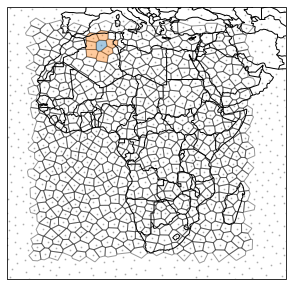

In [11]:
# create a basic map with some geographic features including coastlines and country borders
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# draw the voronoi grid
centers.plot(ax=ax, markersize=1, alpha=.2, color='k')
polygons.plot(ax=ax, facecolor='none', edgecolor='k', alpha=.4)

# for some random pixel, color it and its neighbors
for i in range(1):
    randpix = np.random.choice(polygons.index)
    polygons.iloc[[randpix]].plot(ax=ax,
                                facecolor='C0',
                                alpha=.4)
    polygons.iloc[polygons['neighbors'].iloc[randpix]].plot(ax=ax,
                                                            facecolor='C1',
                                                            alpha=.4)

# center the boundaries of the map about Africa
ax.set_extent(array([0.05235987755982988+330/180*pi, 1.6406094968746698+330/180*pi,
                     -0.5853981633974483, 0.6203047484373349])*180/pi)

# Visualize all cells

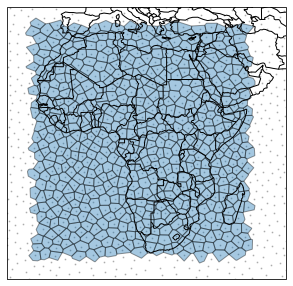

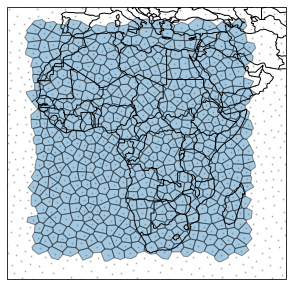

In [6]:
# set inverse solid angle; large values of dx will take longer to plot
dx = 80

# iterate thru grids and plot all grid cells used to analyze Africa;
# these are a subset having excluded polygons that do not intersect with the landmass;
# see further examples below
for gridix in range(2):
    load_pickle(f'{wd}/voronoi_grids/{dx}/{str(gridix).zfill(2)}.p')

    centers = [Point(x, y) for x, y in transform(poissd.samples)]
    centers = gpd.GeoSeries(centers, crs='EPSG:4087')

    polygons = gpd.read_file(f'{wd}/voronoi_grids/{dx}/borders{str(gridix).zfill(2)}.shp')

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

    centers.plot(ax=ax, markersize=1, alpha=.2, color='k')
    polygons.plot(ax=ax, facecolor='C0', edgecolor='k', alpha=.4)
    
    ax.set_extent(array([0.05235987755982988+330/180*pi, 1.6406094968746698+330/180*pi,
                         -0.5853981633974483, 0.6203047484373349])*180/pi)

# Combining polygons with a raster file
This is an example of how we can map geographic information from a raster file to the voronoi cells. In this case, we are counting total population number.

In [7]:
rasterfile = f'{wd}/population_af/combined_.025.tif'  # path to raster file
gridix = 0

def pop_by_dx(dx):
    """Extract population statistics per voronoi grid cell from a GeoTIF file 
    of population number.
    
    Parameters
    ----------
    dx : float
        Inverse solid angle.
        
    Returns
    -------
    ndarray
        Total population number per voronoi cell.
    """
    
    cellfile = f'{wd}/voronoi_grids/{dx}/borders{str(gridix).zfill(2)}.shp'
    polygons = gpd.read_file(cellfile)
    
    # sums up all the raster pixels that fall within the boundaries of a voronoi cell;
    # I am not sure how pixels falling on more than one cell are treated
    return np.array([i['sum'] if i['sum'] else 0 for i in 
                    zonal_stats(cellfile, rasterfile, band=1, stats=['sum'])])

# put population maps into a dict
pop = {}
for dx in [80,160,320]:
    pop[dx] = pop_by_dx(dx)

<ipython-input-8-28abb6779039>:8: RuntimeWarning: divide by zero encountered in log
  logr = log(pop[dx])


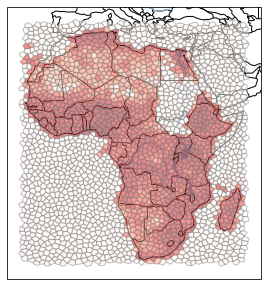

In [8]:
dx = 160

# load voronoi cells
cellfile = f'{wd}/voronoi_grids/{dx}/borders{str(gridix).zfill(2)}.shp'
polygons = gpd.read_file(cellfile)

# put population number on log scale
logr = log(pop[dx])
logr[~isfinite(logr)] = 0

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# plot population number by voronoi cell
polygons.plot(ax=ax,
              facecolor=[plt.cm.Reds(i) for i in logr/logr.max()],
              edgecolor='gray',
              alpha=.5,
              zorder=3)